# OpenFE - Planning Free energy transformations

In this notebook we are going to have a look on the current status of the OpenFE package and how transformation networks for relative free energy calculations can be set up on a detailed level.

The notebook is seperated into multiple steps:
* Input
* Generating Atom Mappings
* Atom Mapping Scoring
* Build Networks


## The Input:

Let's first load a molecule of choice into the OpenFe-Environment. 

In [1]:
#no noise :) 
import logging
logging.basicConfig(level=logging.WARNING)

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


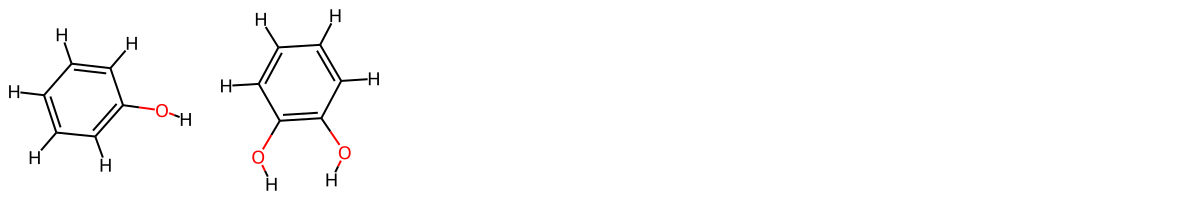

In [2]:
from rdkit import Chem
from openfe import SmallMoleculeComponent

# Starting from Smiles in a dictionary:
name_smiles  = [
('phenol', 'c1ccccc1O'),
('catechol', 'c1cccc(O)c1O'),
]

rd_mols = [Chem.MolFromSmiles(s) for n,s in name_smiles]
rd_mols = [Chem.AddHs(m, addCoords=True) for m in rd_mols]
[Chem.rdDistGeom.EmbedMultipleConfs(m, 1) for m in rd_mols]
[m.SetProp("_Name", n) for (n,s),m in zip(name_smiles, rd_mols)]

# Bring rdkit to openfe:
mols = [SmallMoleculeComponent(m, name=n) for (n,s),m in zip(name_smiles, rd_mols)]

Chem.Draw.MolsToGridImage(rd_mols, molsPerRow=6)


## Step One - Generating Atom Mappings

With the loaded Molecules, we can now go to the first step and start to generate possible atom mappings for the different transformations. 
These mappings are required in our RBFE-Protocol as we are running hybrid topology approaches, in which we try to keep the common core of two molecules as identical coordinates and the diverging atoms as seperated coordinates.
In the end we will simulate a intermediate molecule of the both ligands, where we turn on and off the different atoms to simulate the different end-states and intermediates.

Let's start with a single mapping.

In [19]:
from openfe.utils.visualization_3D import show_component_coords
from kartograf.atom_mapping.geom_align import align_mol_sceletons

molA = mols[0]
molB = mols[1]
molB = align_mol_sceletons(ref_mol=molA, mol=molB)
show_component_coords([molA, molB])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

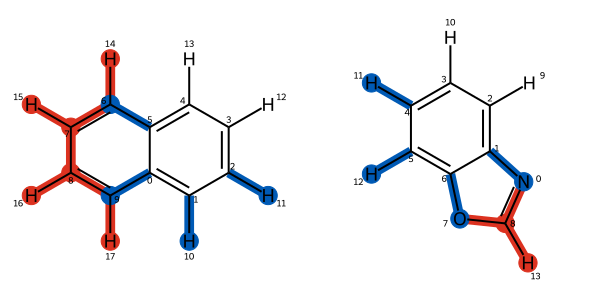

In [20]:
from openfe import setup

lomap_mapper = setup.LomapAtomMapper()

mapping = next(lomap_mapper.suggest_mappings(molA, molB))
mapping

In [21]:
from openfe.utils.visualization_3D import show_3D_mapping
show_3D_mapping(mapping)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Lomap and GeomAtomMapper of Kartograf: 

This part want to showcase differences between Lomap and the GeomAtomMapper of Kartograf.

Lomap is a Atom mapper, that uses a lot of chemical information in order to map the ligands.
GeomAtomMapper of Kartograf on the other side mainly focuses on the coordinates of the ligand, as they were modelled before.

So GeomAtomMapper is trying to preserve the coordinates given as best as possible, whereas Lomap tries to match chemical property matches.

One thing we found, that could be better solved by GeomAtomMapper is Stereo Center - Flips.
let's have a small example here, checkout closely how the different atom mapper treat the stereocenter. In this case this might not be a problem, but if you think about stereochemistry in rings it gets a different stroy.

In [22]:
from rdkit import Chem

from openfe import SmallMoleculeComponent, setup
from openfe.utils.visualization_3D import show_component_coords, show_3D_mapping
from kartograf.atom_mapping.geom_align import align_mol_sceletons


smiles = [ "C[C@H](F)Br",
          "C[C@@H](F)Br",
          ]

rd_mols = [Chem.MolFromSmiles(s) for s in smiles]
rd_mols = [Chem.AddHs(m, addCoords=True) for m in rd_mols]
[Chem.rdDistGeom.EmbedMultipleConfs(m, 1) for m in rd_mols]
mols = [SmallMoleculeComponent(m) for m in rd_mols]
align_mol_sceletons(ref_mol=mols[0], mol=mols[1])
show_component_coords(mols, shift=[5,0,0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

{1: 1, 2: 2, 3: 3, 7: 7}


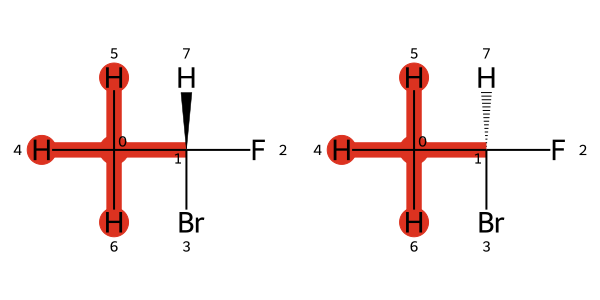

In [23]:
#Do mapping with Lomap:
lomap_mapper = setup.LomapAtomMapper()
lomap_mapping = next(lomap_mapper.suggest_mappings(mols[0], mols[1]))

# #Do mapping with Kartograf:
geom_atom_mapper = setup.GeomAtomMapper(atom_map_hydrogens=True)
kartograf_mapping = next(geom_atom_mapper.suggest_mappings(mols[0], mols[1]))

print(lomap_mapping.componentA_to_componentB)
lomap_mapping

In [24]:
show_3D_mapping(lomap_mapping)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

{2: 7, 6: 5, 7: 2, 0: 0, 1: 1, 3: 3}


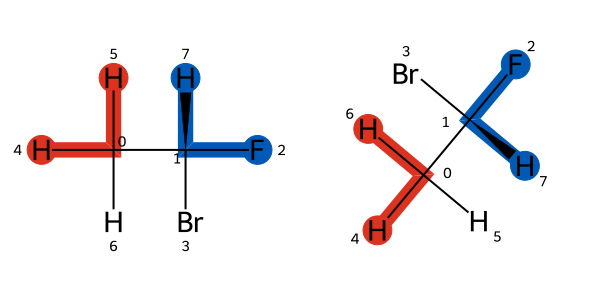

In [25]:
print(kartograf_mapping.componentA_to_componentB)
kartograf_mapping

In [26]:
show_3D_mapping(kartograf_mapping)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Step Two - Atom Mapping Scoring
How can we compare different mappings? 
In practices of course not only two ligands are usually of interest. To be able to identify the best transformations between multiple ligands, a way to score atom mappings is required.

Below you will find multiple metrics, that could be used to compare the mappings.

In [11]:
#Number of mapped atoms:
print("Mapping comparisons")
n_lomap = len(lomap_mapping.componentA_to_componentB)
n_kartograf = len(kartograf_mapping.componentA_to_componentB)
print(f"Lomap mapped atoms: {n_lomap}")
print(f"Kartograf mapped atoms: {n_kartograf}")


# Getting the distances of the mapped atoms:
print("\n geometric measures")
lomap_dist = lomap_mapping.get_distances()
kartograf_dist = kartograf_mapping.get_distances()
print(f"Lomap atom distances: {lomap_dist}")
print(f"Kartograf atom distances: {kartograf_dist}")

import numpy as np
lomap_atom_avg_dist = np.mean(lomap_dist)
lomap_atom_avg_std = np.std(lomap_dist)
kartograf_atom_avg_dist = np.mean(kartograf_dist)
kartograf_atom_avg_std = np.std(kartograf_dist)
print("Avg distace of Lomap mapping: {:.2f} +- {:.2f}".format(lomap_atom_avg_dist, lomap_atom_avg_std))
print("Avg distace of Kartograf mapping: {:.2f} +- {:.2f}".format(kartograf_atom_avg_dist, kartograf_atom_avg_std))

Mapping comparisons
Lomap mapped atoms: 4
Kartograf mapped atoms: 8

 geometric measures
Lomap atom distances: [0.18193531 2.02222953 0.24093408 2.0291002 ]
Kartograf atom distances: [0.33854318 0.41965609 0.36440268 0.1289221  0.27256488 0.08538386
 0.18193531 0.24093408]
Avg distace of Lomap mapping: 1.12 +- 0.91
Avg distace of Kartograf mapping: 0.25 +- 0.11


In [12]:
from openfe.setup import lomap_scorers

lomap_lomap_score = np.round(lomap_scorers.default_lomap_score(lomap_mapping),2)
kartograf_lomap_score = np.round(lomap_scorers.default_lomap_score(kartograf_mapping),2)

print("Lomap scores: ")
print("Lomap mapping: ", lomap_lomap_score)
print("Kartograf mapping: ", kartograf_lomap_score)

Lomap scores: 
Lomap mapping:  0.18
Kartograf mapping:  0.18


In [13]:
from kartograf.atom_mapping import geom_scorer

lomap_lomap_score = np.round(geom_scorer.mappings_rmsd(lomap_mapping),2)
kartograf_lomap_score = np.round(geom_scorer.mappings_rmsd(kartograf_mapping),2)

print("Lomap scores: ")
print("Lomap mapping: ", lomap_lomap_score)
print("Kartograf mapping: ", kartograf_lomap_score)

Lomap scores: 
Lomap mapping:  2.88
Kartograf mapping:  0.78


In [14]:
from kartograf.atom_mapping import geom_scorer

lomap_lomap_score = np.round(geom_scorer.mapping_volume_ratio(lomap_mapping),2)
kartograf_lomap_score = np.round(geom_scorer.mapping_volume_ratio(kartograf_mapping),2)

print("Lomap scores: ")
print("Lomap mapping: ", lomap_lomap_score)
print("Kartograf mapping: ", kartograf_lomap_score)

Lomap scores: 
Lomap mapping:  0.94
Kartograf mapping:  0.0


## Step Three - Building Networks
Togehter the mappers and the scorers can be used to construct networks. The networks represent a collection of good transformations (from a ligand perspective), that can be calculated with for example the RBFE-Protocol.
The networks are the final stage, before getting to real simulations, that will be done with Protocols. We are planning for the future to wrap this setup approach into a so called Campaigner to make the planning of FE-Campaigns as easy as possible.

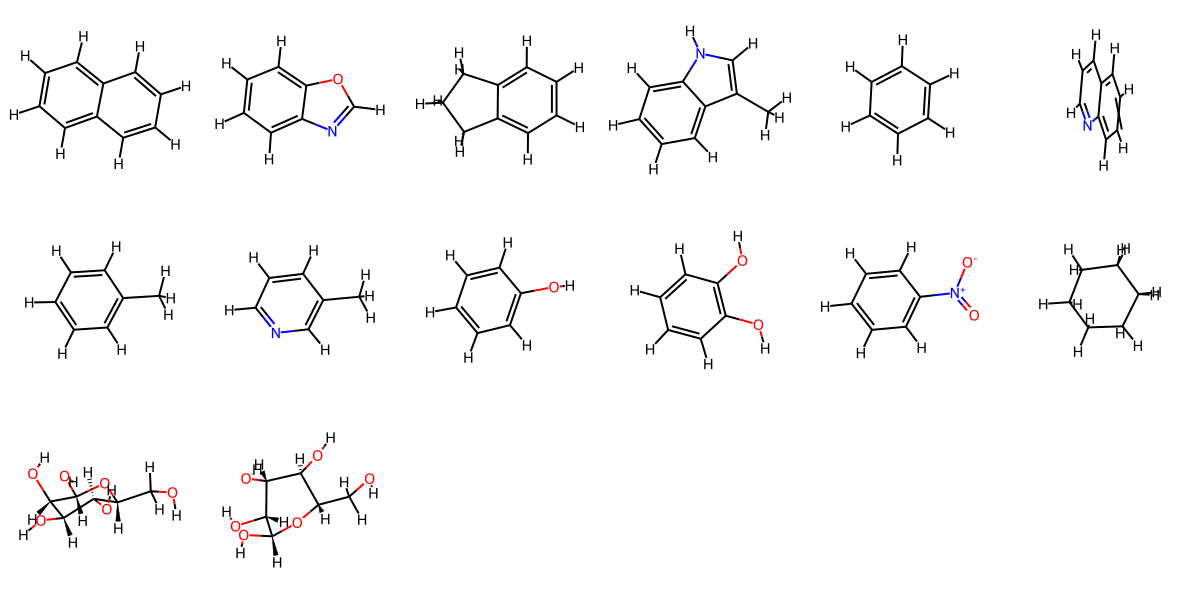

In [15]:
# Build a set of Molecules:
from rdkit import Chem
from openfe import SmallMoleculeComponent
from kartograf.atom_mapping.geom_align import align_mol_sceletons

# Starting from Smiles in a dictionary:
name_smiles  = [
('naphthalene', 'c12ccccc1cccc2'),
('benzoxazole', 'n1c2ccccc2oc1'),
('indane', 'c1ccc2c(c1)CCC2'),
('skatole', 'CC1=CNC2=CC=CC=C12'),
('benzene', 'c1ccccc1'),
('quinoline', 'n1cccc2ccccc12'),
('toluene', 'c1ccccc1C'),
('methylpyridine', 'c1ccncc1C'),
('phenol', 'c1ccccc1O'),
('catechol', 'c1cccc(O)c1O'),
('nitrobenzene', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
('cyclohexane', 'C1CCCCC1'),
('d-glucose', '[C@H](CO)1[C@@H](O)[C@H](O)[C@H](O)[C@H](O)O1'),
('l-glucose', '[C@@H](CO)1[C@H](O)[C@@H](O)[C@@H](O)[C@@H](O)O1'),
]

rd_mols = [Chem.MolFromSmiles(s) for n,s in name_smiles]
rd_mols = [Chem.AddHs(m, addCoords=True) for m in rd_mols]
[Chem.rdDistGeom.EmbedMultipleConfs(m, 1) for m in rd_mols]
[m.SetProp("_Name", n) for (n,s),m in zip(name_smiles, rd_mols)]

# Bring rdkit to openfe:
mols = [SmallMoleculeComponent(m, name=n) for (n,s),m in zip(name_smiles, rd_mols)]
[align_mol_sceletons(ref_mol=mols[4], mol=mol) for mol in mols]
Chem.Draw.MolsToGridImage(rd_mols, molsPerRow=6)


In [16]:
# build a simple transformation network:
from openfe import setup
from openfe.setup import  ligand_network_planning
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score
from kartograf.atom_mapping.geom_scorer import mapping_volume_ratio

ligand_network_kartograf = ligand_network_planning.generate_minimal_spanning_graph(ligands=mols,
                                                        mappers=[setup.GeomAtomMapper()],
                                                        scorer=mapping_volume_ratio)

ligand_network_lomap = ligand_network_planning.generate_minimal_spanning_graph(ligands=mols,
                                                        mappers=[setup.LomapAtomMapper()],
                                                        scorer=default_lomap_score)

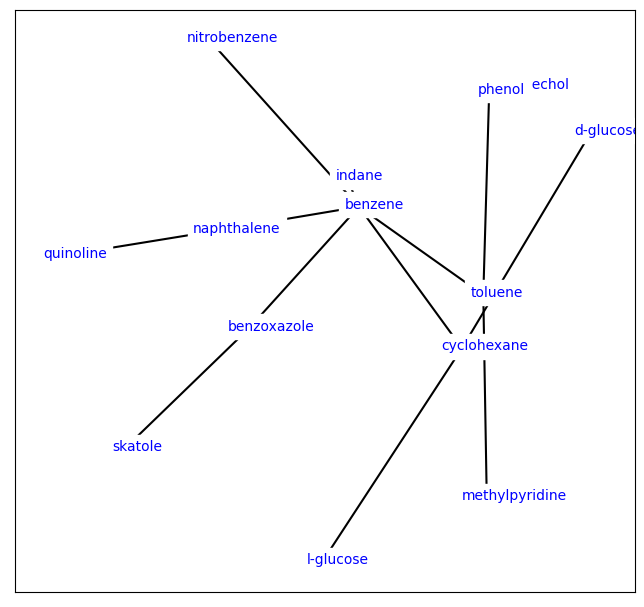

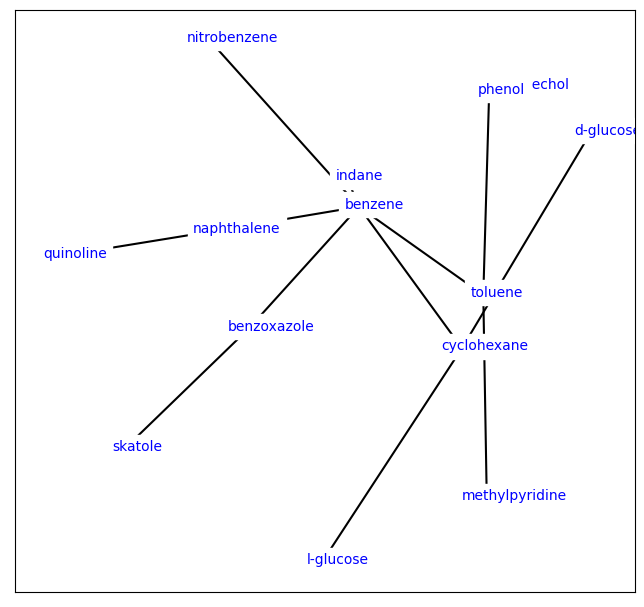

In [17]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network_lomap)

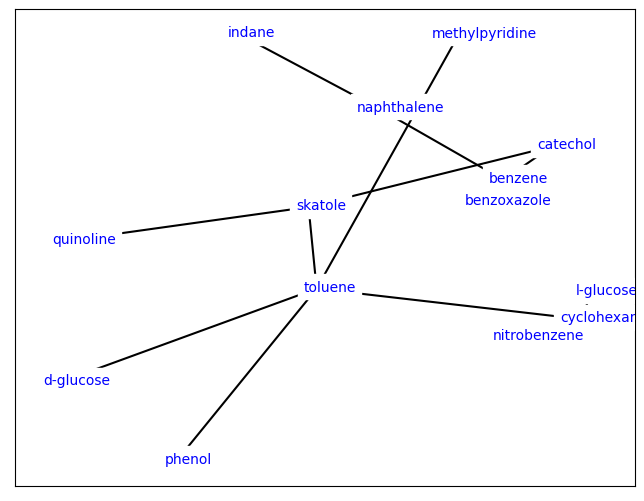

In [18]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network_kartograf)
